**Housekeeping**

In [4]:
import zipfile
import os

In [5]:
def extract(zipped_path, extracted_path):
  with zipfile.ZipFile(zipped_path, "r") as zip_ref:
    zip_ref.extractall(extracted_path)

In [6]:
current_dir = os.getcwd()
#directory to unzip to
os.mkdir(os.path.join(current_dir, "tweet-data2"))

zipped_path = os.path.join(current_dir, "tweets.zip")
extracted_path = os.path.join(current_dir, "tweet-data2")


extract(zipped_path, extracted_path)

In [7]:
os.listdir(extracted_path)

['training.csv', 'validation.csv', 'test.csv']

**Load data and EDA**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
train = pd.read_csv(os.path.join(extracted_path, "training.csv"))
validation = pd.read_csv(os.path.join(extracted_path, "validation.csv"))
test = pd.read_csv(os.path.join(extracted_path, "test.csv"))

In [10]:
train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [11]:
#add new column matching integer label with correct emotion
labels = {0:"sadness", 1:"joy", 2:"love", 3:"anger", 4:"fear", 5:"surprise"}
train["emotion"] = train["label"].map(labels)
train.head()

,text,label,emotion
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Distribution of emotion labels in train data

surprise     572
love        1304
fear        1937
anger       2159
sadness     4666
joy         5362
Name: emotion, dtype: int64


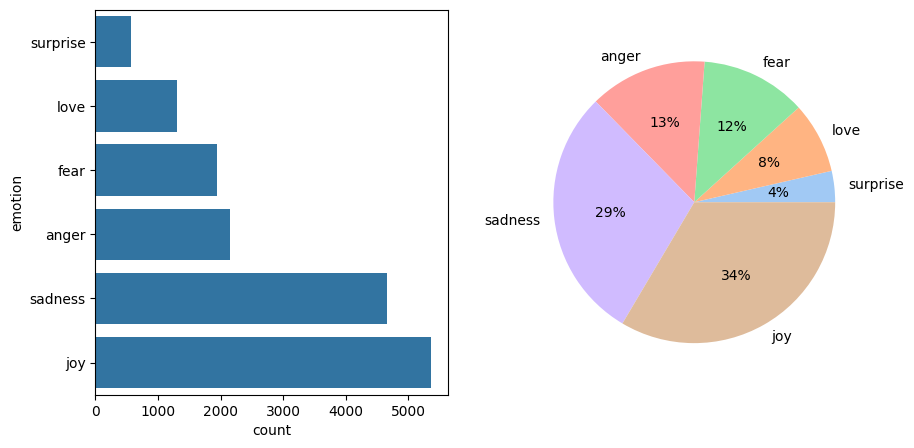

In [12]:
#create subplots for plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
#count amount of labels and add countplot
counts = train["emotion"].value_counts().sort_values()
print(counts)
a = ax[0]
sns.countplot(train["emotion"],order=counts.index, ax=a)
#add pie chart distribution
wedges = ax[1].pie(counts.values, labels=counts.index, autopct='%.0f%%', colors=sns.color_palette("pastel"))
plt.show()


Distribution of length of tweets for each emotion

In [13]:
#create new column counting length of texts
train["text_length"] = train["text"].apply(len)

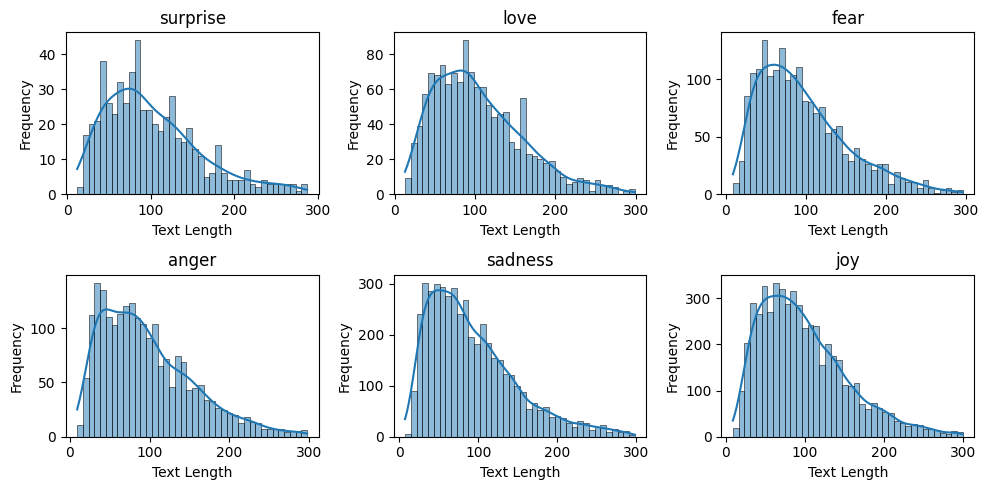

In [14]:
emotions = ["surprise", "love", "fear", "anger", "sadness", "joy"]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,5))

for axes, emotion_label in zip(ax.flatten(), emotions):
    #create histogram showing frequency of text lengths for each emotion label
    sns.histplot(train[train["emotion"] == emotion_label]["text_length"], bins=40, kde=True, ax=axes)
    axes.set_title(emotion_label)
    axes.set_xlabel("Text Length")
    axes.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

Distribution of word count in tweet for each emotion

In [15]:
#create new column counting words for each tweet
train["word_count"] = train["text"].apply(lambda x: len(str(x).split()))
train.head()

,text,label,emotion,text_length,word_count
0,i didnt feel humiliated,0,sadness,23,4
1,i can go from feeling so hopeless to so damned...,0,sadness,108,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,48,10
3,i am ever feeling nostalgic about the fireplac...,2,love,92,18
4,i am feeling grouchy,3,anger,20,4


<Axes: xlabel='emotion', ylabel='word_count'>

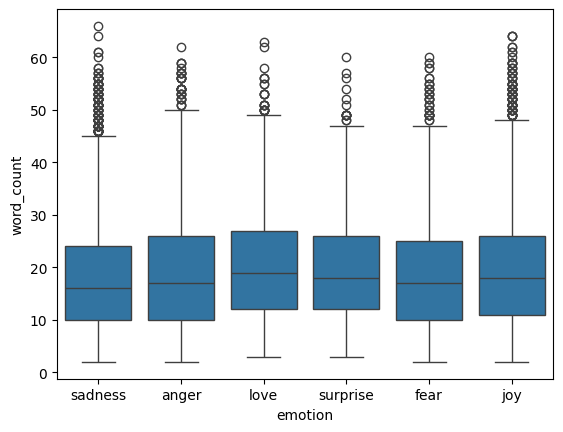

In [16]:
#create boxplot to show frequency of word counts for each emotion
sns.boxplot(x="emotion", y="word_count", data=train)

Distribution of unigrams and bigrams for each emotion

In [17]:
#calculate ngrams
from sklearn.feature_extraction.text import CountVectorizer

def get_ngram(corpus, ngram_range, n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words = "english").fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum = bag_of_words.sum(axis=0)
    words_freq = [(word, sum[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [18]:
#gather all the texts from each emotion
surprise = train[train["emotion"]=="surprise"]['text'].values
love = train[train["emotion"]=="love"]['text'].values
fear = train[train["emotion"]=="fear"]['text'].values
anger = train[train["emotion"]=="anger"]['text'].values
sadness = train[train["emotion"]=="sadness"]['text'].values
joy = train[train["emotion"]=="joy"]['text'].values

In [19]:
#calculate unigrams
surprise_uni = get_ngram(surprise, (1,1), 5)
love_uni = get_ngram(love, (1,1), 5)
fear_uni = get_ngram(fear, (1,1), 5)
anger_uni = get_ngram(anger, (1,1), 5)
sadness_uni = get_ngram(sadness, (1,1), 5)
joy_uni = get_ngram(joy, (1,1), 5)

#calculate bigrams
surprise_bi = get_ngram(surprise, (2,2), 5)
love_bi = get_ngram(love, (2,2), 5)
fear_bi = get_ngram(fear, (2,2), 5)
anger_bi = get_ngram(anger, (2,2), 5)
sadness_bi = get_ngram(sadness, (2,2), 5)
joy_bi = get_ngram(joy, (2,2), 5)

In [20]:
unigrams = [surprise_uni, love_uni, fear_uni, anger_uni, sadness_uni, joy_uni]
bigrams = [surprise_bi, love_bi, fear_bi, anger_bi, sadness_bi, joy_bi]

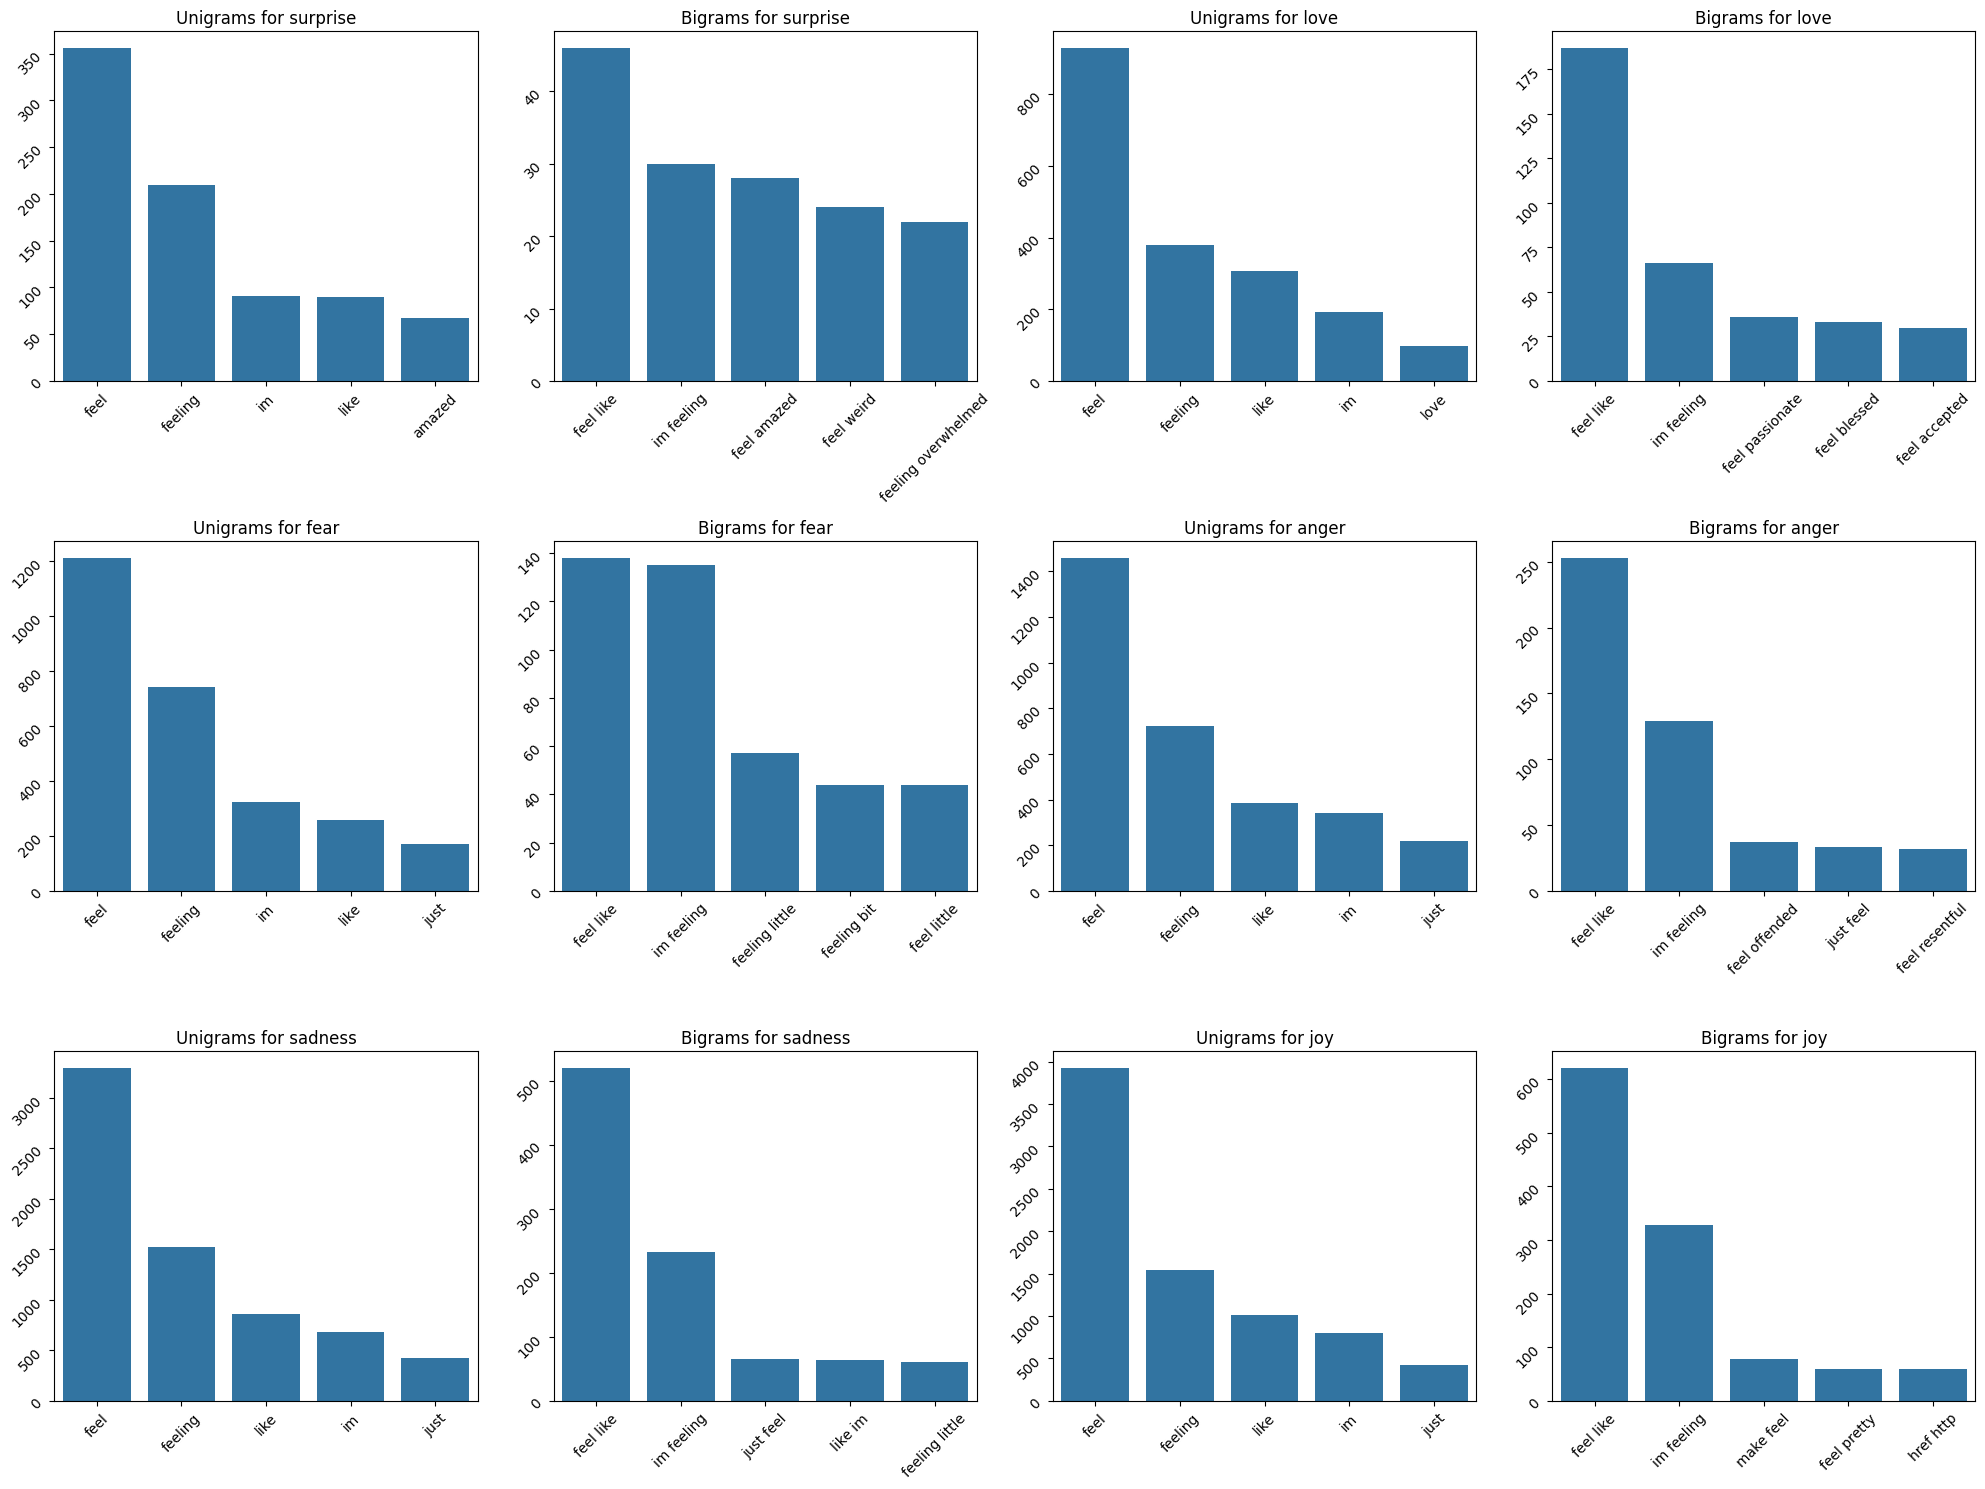

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20,15))
#loop through each emotion, plotting unigram and bigram frequencies
for i in range(6):
  #get row and column indices for subplot
  r = i // 2
  c = 0 if i%2==0 else 2 #col index starts at 0 and then index 2 when iterate to next emotion
  #plot unigram
  sns.barplot(x=list(dict(unigrams[i]).keys()), y=list(dict(unigrams[i]).values()),ax=ax[r][c])
  ax[r][c].set_title(f'Unigrams for {emotions[i]}')
  ax[r][c].tick_params(labelrotation=45)
  #plot bigram
  sns.barplot(x=list(dict(bigrams[i]).keys()), y=list(dict(bigrams[i]).values()),ax=ax[r][c+1])
  ax[r][c+1].set_title(f'Bigrams for {emotions[i]}')
  ax[r][c+1].tick_params(labelrotation=45)
plt.tight_layout()
plt.show()


**Tokenization and preprocessing**

In [22]:
#collect all text from train test val data
full_text = train["text"].to_list() + test["text"].to_list() + validation["text"].to_list()
len(full_text)

20000

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer

#tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(full_text)
word_index = tokenizer.word_index

In [37]:
vocab_size = len(word_index)+1

In [38]:
vocab_size

17097

In [25]:
#convert texts to numbers
def preprocess(df):
  data = []
  for index, row in df.iterrows():
    #split text to individual words
    split_words = row["text"].split()
    #convert words to numerical sequence
    tokens = tokenizer.texts_to_sequences([split_words])[0]
    data.append(tokens)
  return data

In [26]:
X_train = preprocess(train)
print(train["text"][:2])
print(X_train[:2])

0                              i didnt feel humiliated
1    i can go from feeling so hopeless to so damned...
Name: text, dtype: object
[[1, 138, 2, 625], [1, 39, 101, 59, 7, 14, 522, 4, 14, 3128, 545, 31, 59, 61, 128, 144, 71, 1699, 3, 21, 1383]]


In [27]:
X_val = preprocess(validation)
print(validation["text"][:2])
print(X_val[:2])

0    im feeling quite sad and sorry for myself but ...
1    i feel like i am still looking at a blank canv...
Name: text, dtype: object
[[15, 7, 154, 253, 3, 332, 16, 50, 20, 213, 3978, 49, 9, 12, 527], [1, 2, 13, 1, 23, 69, 249, 32, 6, 607, 2449, 607, 1505, 9, 1130]]


In [28]:
#pad sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

#find max sequence length
max_len = max(len(sequence) for sequence in X_train)
print("max sequence len: ", max_len)

max sequence len:  66


In [29]:
#pad X_train
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding="post")

#pad X_val
X_val_padded = pad_sequences(X_val, maxlen=max_len, padding="post")

In [50]:
X_train = np.array(X_train_padded)
X_val = np.array(X_val_padded)

#gather the labels
y_train = np.array(train["label"].to_list())
y_val = np.array(validation["label"].to_list())

print("shape of training data:", X_train.shape, y_train.shape)
print("shape of val data:", X_val.shape, y_val.shape)

shape of training data: (16000, 66) (16000,)
shape of val data: (2000, 66) (2000,)


In [51]:
#one hot encode labels
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=6)
y_val = to_categorical(y_val, num_classes=6)

**Build model**

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=66))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.5))
model.add(Dense(6, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 66, 100)           1709700   
                                                                 
 bidirectional_10 (Bidirect  (None, 66, 200)           160800    
 ional)                                                          
                                                                 
 bidirectional_11 (Bidirect  (None, 200)               240800    
 ional)                                                          
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 1206      
                                                                 
Total params: 2112506 (8.06 MB)
Trainable params: 2112

In [56]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [57]:
history = model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/20
500/500 [==============================] - 172s 328ms/step - loss: 1.0022 - accuracy: 0.6252 - val_loss: 0.4105 - val_accuracy: 0.8620
Epoch 2/20
500/500 [==============================] - 162s 324ms/step - loss: 0.2617 - accuracy: 0.9136 - val_loss: 0.2652 - val_accuracy: 0.9095
Epoch 3/20
500/500 [==============================] - 159s 319ms/step - loss: 0.1811 - accuracy: 0.9385 - val_loss: 0.2932 - val_accuracy: 0.9050
Epoch 4/20
500/500 [==============================] - 168s 335ms/step - loss: 0.1143 - accuracy: 0.9628 - val_loss: 0.2559 - val_accuracy: 0.9165
Epoch 5/20
500/500 [==============================] - 165s 329ms/step - loss: 0.0807 - accuracy: 0.9712 - val_loss: 0.2841 - val_accuracy: 0.9165
Epoch 6/20
500/500 [==============================] - 165s 330ms/step - loss: 0.0695 - accuracy: 0.9759 - val_loss: 0.3006 - val_accuracy: 0.9125
Epoch 7/20
500/500 [==============================] - 161s 322ms/step - loss: 0.0572 - accuracy: 0.9802 - val_loss: 0.3229 -

**Results and evaluation**

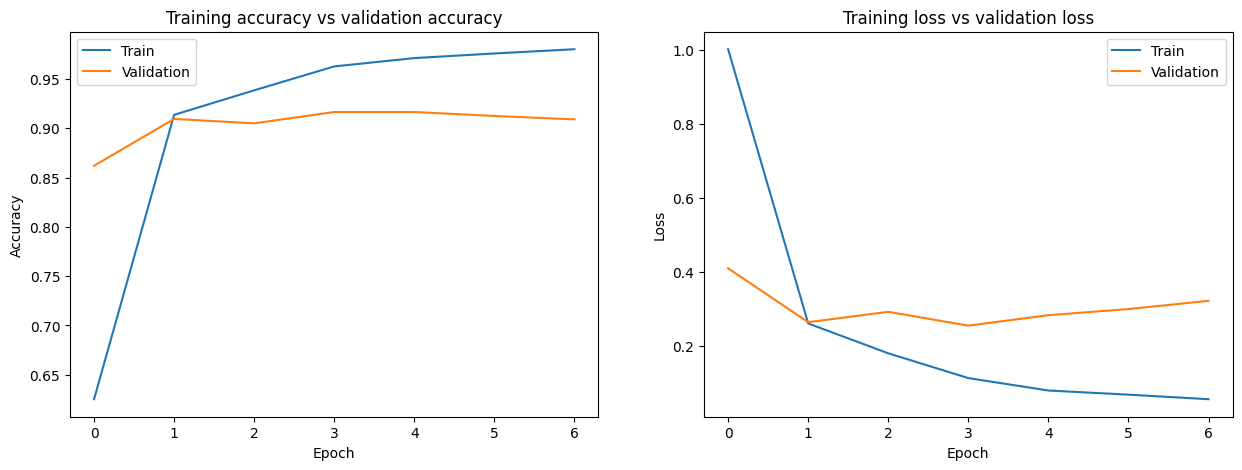

In [64]:
#plot accuracy and loss
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(history.history["accuracy"], label="Train")
ax[0].plot(history.history["val_accuracy"], label="Validation")
ax[0].set_title("Training accuracy vs validation accuracy")
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].legend()

ax[1].plot(history.history["loss"], label="Train")
ax[1].plot(history.history["val_loss"], label="Validation")
ax[1].set_title("Training loss vs validation loss")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].legend()

Make predictions on test set

In [69]:
X_test = preprocess(test)
X_test_padded = pad_sequences(X_test, maxlen=max_len, padding="post")
X_test = np.array(X_test_padded)
y_test = np.array(test["label"].to_list())

In [77]:
predictions = model.predict(X_test)
predictions

63/63 [==============================] - 8s 134ms/step


array([[9.9819976e-01, 5.9296627e-04, 2.2633121e-04, 7.7040790e-04,
        1.5870856e-04, 5.1833944e-05],
       [9.9848145e-01, 3.9565211e-04, 8.5920365e-05, 7.5703976e-04,
        2.5401879e-04, 2.5920044e-05],
       [9.9851668e-01, 3.5542887e-04, 7.6293618e-05, 7.9650490e-04,
        2.3260619e-04, 2.2460486e-05],
       ...,
       [1.4775282e-03, 9.9195045e-01, 2.8659136e-03, 2.6056094e-03,
        8.9728046e-04, 2.0319482e-04],
       [1.5975887e-01, 8.1673402e-01, 1.3301218e-02, 8.3002457e-03,
        1.3465044e-03, 5.5914809e-04],
       [7.1405410e-04, 3.2154000e-03, 6.1002239e-03, 1.7510801e-04,
        4.1802064e-02, 9.4799328e-01]], dtype=float32)

In [80]:
predicted_labels = [np.argmax(pred) for pred in predictions]

Confusion matrix and accuracy

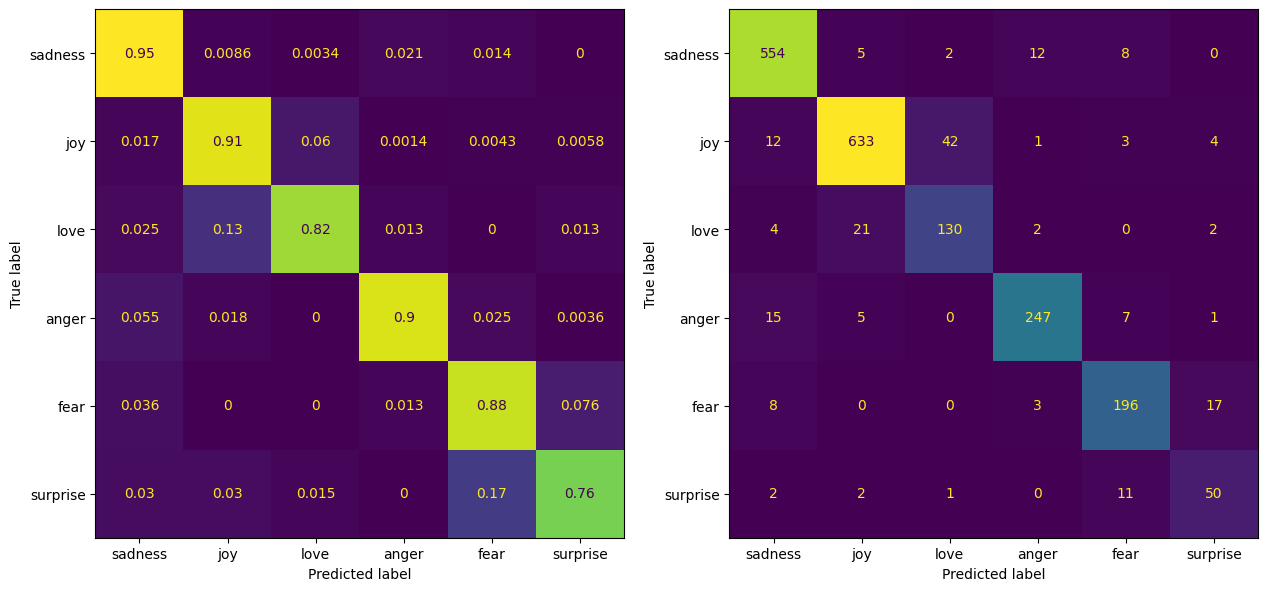

In [123]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score

fig, ax = plt.subplots(1, 2, figsize=(15,15))
cm_normalized = confusion_matrix(y_test, predicted_labels, normalize="true")
display = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=labels.values())
display.plot(ax=ax[0], colorbar=False)
plt.grid(False)

cm = confusion_matrix(y_test, predicted_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels.values())
display.plot(ax=ax[1], colorbar=False)
plt.grid(False)

In [124]:
print("Accuracy: ",accuracy_score(y_test, predicted_labels))

Accuracy:  0.905


In [104]:
#display some predictions
for i in range(10):
  print(f"Prediction {i+1}")
  print("Text: ", test["text"][i])
  print("Predicted label: ", labels[predicted_labels[i]])
  print("Actual label: ", labels[test["label"][i]])
  print("\n")

Prediction 1
Text:  im feeling rather rotten so im not very ambitious right now
Predicted label:  sadness
Actual label:  sadness


Prediction 2
Text:  im updating my blog because i feel shitty
Predicted label:  sadness
Actual label:  sadness


Prediction 3
Text:  i never make her separate from me because i don t ever want her to feel like i m ashamed with her
Predicted label:  sadness
Actual label:  sadness


Prediction 4
Text:  i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
Predicted label:  joy
Actual label:  joy


Prediction 5
Text:  i was feeling a little vain when i did this one
Predicted label:  sadness
Actual label:  sadness


Prediction 6
Text:  i cant walk into a shop anywhere where i do not feel uncomfortable
Predicted label:  fear
Actual label:  fear


Prediction 7
Text:  i felt anger when at the end of a telephone call
Predicted label:  joy
Actual label:  anger


Prediction 8
Text:  i explain why i clung to 